# Stats Canada Total Deaths Stats

This notebook allows you to get all the reported deaths by province and by age from stats Canada and organize the data into some charts and allow you to run statistics on the data

In [262]:
import requests
import pandas as pd
from io import StringIO
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


### Number of years to use

In [263]:
Years = 10

### Build the Url's for stats canada with the desired number of years

In [264]:
today = datetime.now()

EndDate = today.strftime("%Y%m%d")

StartDateCalc = today - timedelta(days=(Years*365))

StartDate = StartDateCalc.strftime("%Y%m%d")

url = f"https://www150.statcan.gc.ca/t1/tbl1/en/dtl!downloadDbLoadingData-nonTraduit.action?pid=1310076801&latestN=0&startDate={StartDate}&endDate={EndDate}&csvLocale=en&selectedMembers=%5B%5B%5D%2C%5B%5D%2C%5B1%5D%2C%5B%5D%5D&checkedLevels=0D2%2C1D2%2C3D1"
CauseUrl = f"https://www150.statcan.gc.ca/t1/tbl1/en/dtl!downloadDbLoadingData-nonTraduit.action?pid=1310081001&latestN=0&startDate={StartDate}&endDate={EndDate}&csvLocale=en&selectedMembers=%5B%5B%5D%2C%5B2%2C5%2C6%2C8%2C10%2C12%2C16%5D%2C%5B%5D%5D&checkedLevels=0D2%2C1D1%2C2D1"


### Get the data from stats canada

In [265]:
ReturnedData = requests.get(url).text

ReturnedCauseData = requests.get(CauseUrl).text

In [266]:
ReturnedCauseData = ReturnedCauseData.replace(", place of occurrence", '')

TempCause = StringIO(ReturnedCauseData)

ReadCauseData = pd.read_csv(TempCause, parse_dates=["REF_DATE"])

#ReadCauseData.head()

### Data Cleanup

In [267]:
CleanedData = ReturnedData.replace(', place of occurrence', '').replace('Age at time of death,', '')


### Read the data received from stats canada and read it using pandas 

In [268]:
tempFile = StringIO(CleanedData)

ReadCsv = pd.read_csv(tempFile, parse_dates=["REF_DATE"])

#ReadCsv.head()


### Carving out only the data that we need into a new table that we can use for plots and statistics

In [269]:
ReNameDict = {
    'REF_DATE':'Date',
    'GEO':"Prov",
    'Age at time of death':'Age',
    'VALUE':'Number'
}
ReadCsv.rename(columns=ReNameDict, inplace=True)

ParsedTable = ReadCsv[['Date', 'Prov', "Age", 'Number']]

### Grouping table by different columns

In [270]:
OrderByDateList = ParsedTable.groupby('Date').sum('Number')
OrderByAgeList = ParsedTable.groupby('Age').sum('Number')


## All prov total deaths for the time frame

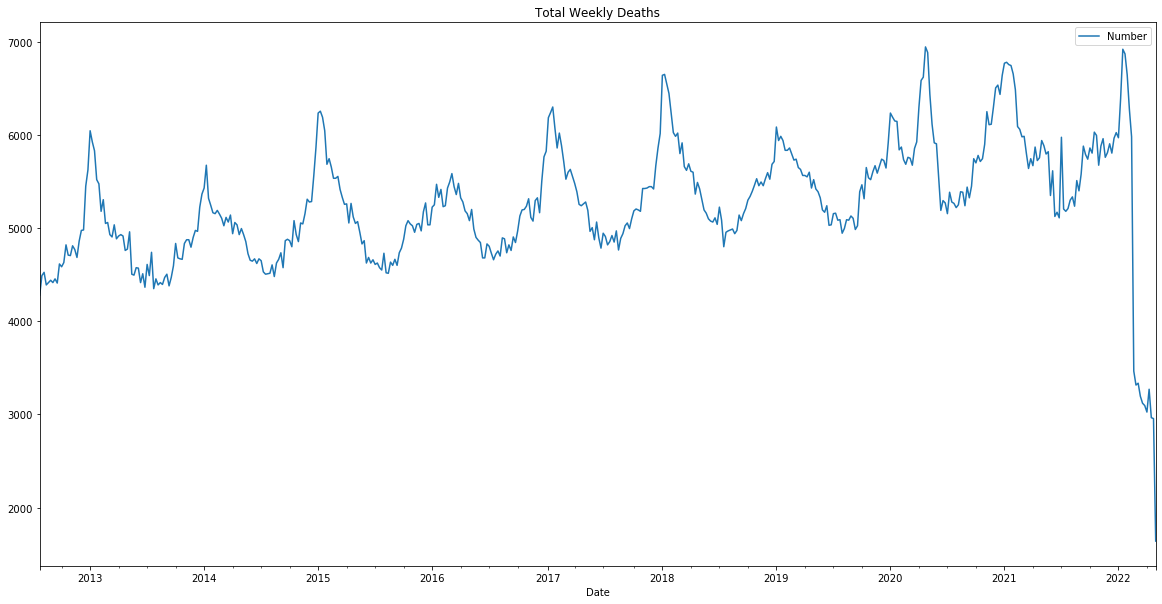

In [284]:
byDate = OrderByDateList.plot(figsize=(20, 10), title='Total Weekly Deaths')
fig = byDate.get_figure()
fig.savefig("Images/Total.png")

### Percentages of Deaths by Age Group

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fddec6f75e0>],
      dtype=object)

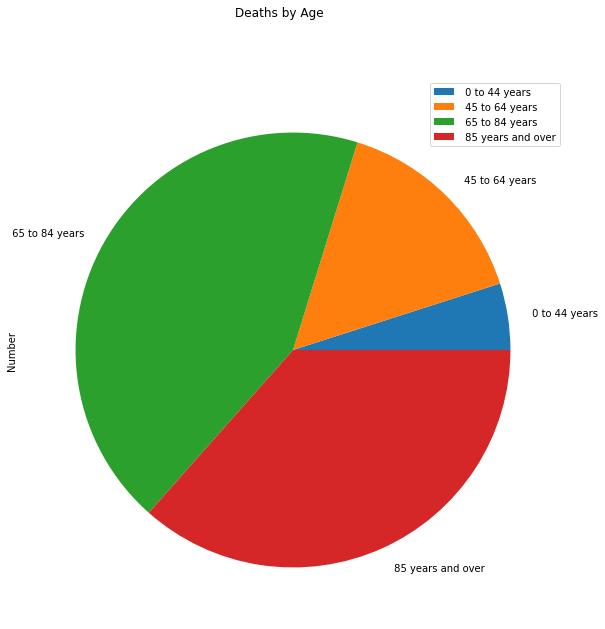

In [272]:
OrderByAgeList.plot(kind='pie', subplots=True, figsize=(15, 10), title='Deaths by Age')

 ## Create groups organized by date for some of the provinces

In [273]:
ab = ParsedTable.loc[ParsedTable['Prov'] == 'Alberta'].groupby('Date').sum('Number')
bc = ParsedTable.loc[ParsedTable['Prov'] == 'British Columbia'].groupby('Date').sum('Number')
sk = ParsedTable.loc[ParsedTable['Prov'] == 'Saskatchewan'].groupby('Date').sum('Number')
mb = ParsedTable.loc[ParsedTable['Prov'] == 'Manitoba'].groupby('Date').sum('Number')
ot = ParsedTable.loc[ParsedTable['Prov'] == 'Ontario'].groupby('Date').sum('Number')

## Subplots showing the difference in total deaths per week per province

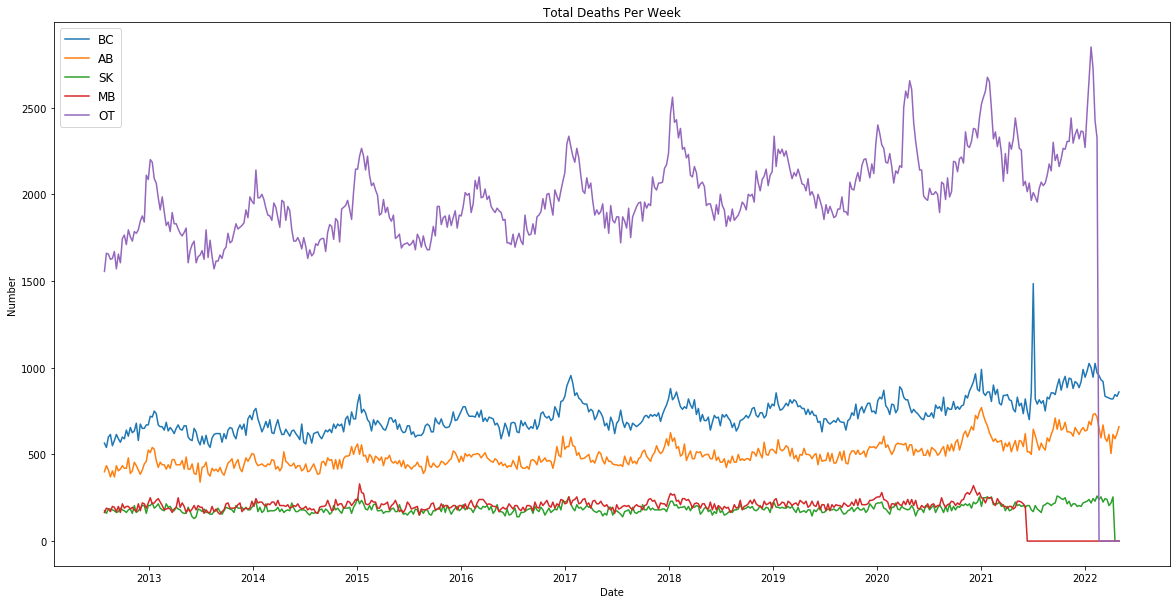

In [287]:
fig, ax = plt.subplots(figsize=(20, 10)) 
plt.title('Total Deaths Per Week')
plt.xlabel('Date')
plt.ylabel('Number')
ax.plot(bc, label='BC')
ax.plot(ab, label='AB')
ax.plot(sk, label='SK')
ax.plot(mb, label='MB')
ax.plot(ot, label='OT')
ax.legend(loc='upper left', fontsize=12)
fig = ax.get_figure()
fig.savefig("Images/Province.png")

### Splitting the data in to the different age groups  

In [275]:
age44 = ParsedTable.loc[ParsedTable['Age'] == ' 0 to 44 years'].groupby('Date').sum('Number')
age64 = ParsedTable.loc[ParsedTable['Age'] == ' 45 to 64 years'].groupby('Date').sum('Number')
age84 = ParsedTable.loc[ParsedTable['Age'] == ' 65 to 84 years'].groupby('Date').sum('Number')
age85 = ParsedTable.loc[ParsedTable['Age'] == ' 85 years and over'].groupby('Date').sum('Number')



## Subplots showing the number of Deaths by age group

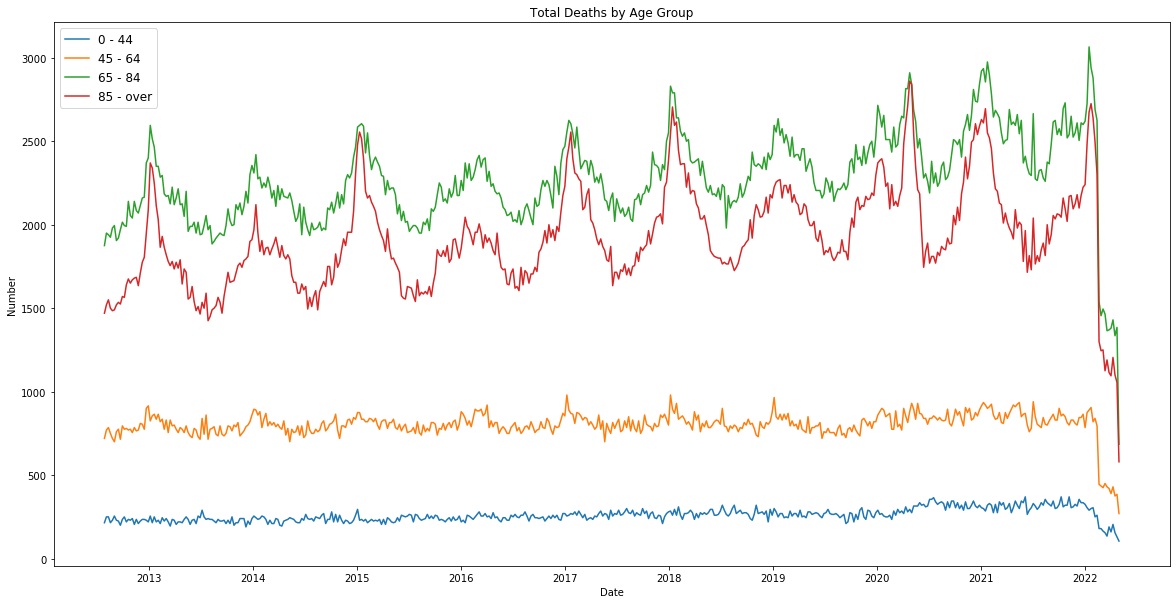

In [276]:
fig, ax_age = plt.subplots(figsize=(20, 10)) 
plt.title('Total Deaths by Age Group')
plt.xlabel('Date')
plt.ylabel('Number')
ax_age.plot(age44, label='0 - 44')
ax_age.plot(age64, label='45 - 64')
ax_age.plot(age84, label='65 - 84')
ax_age.plot(age85, label='85 - over')
ax_age.legend(loc='upper left', fontsize=12)
fig = ax_age.get_figure()
fig.savefig("Images/Age.png")

### Cleaning up the Cause Data

In [277]:
ReNameDict = {
    'REF_DATE':'Date',
    'GEO':"Prov",
    'Cause of death (ICD-10) ':'Cause',
    'VALUE':'Number'
}
ReadCauseData.rename(columns=ReNameDict, inplace=True)
ParsedCauseTable = ReadCauseData[['Date', 'Prov', "Cause", 'Number']]


In [278]:
Causes = ParsedCauseTable.loc[(ParsedCauseTable['Cause'] != 'Total, all causes of death [A00-Y89]') & (ParsedCauseTable['Cause'] != 'Information unavailable')]

In [279]:
Covid = Causes.loc[Causes['Cause'] == 'COVID-19 [U07.1,U07.2]'].groupby('Date').sum('Number')
Cerebro = Causes.loc[Causes['Cause'] == 'Cerebrovascular diseases [I60-I69]'].groupby('Date').sum('Number')
Resp = Causes.loc[Causes['Cause'] == 'Chronic lower respiratory diseases [J40-J47]'].groupby('Date').sum('Number')
Heart = Causes.loc[Causes['Cause'] == 'Diseases of heart [I00-I09, I11, I13, I20-I51]'].groupby('Date').sum('Number')
Neo = Causes.loc[Causes['Cause'] == 'Malignant neoplasms [C00-C97]'].groupby('Date').sum('Number')
Accidents = Causes.loc[Causes['Cause'] == 'Accidents (unintentional injuries) [V01-X59, Y85-Y86]'].groupby('Date').sum('Number')



## Deaths per week by Cause

NameError: name 'imwrite' is not defined

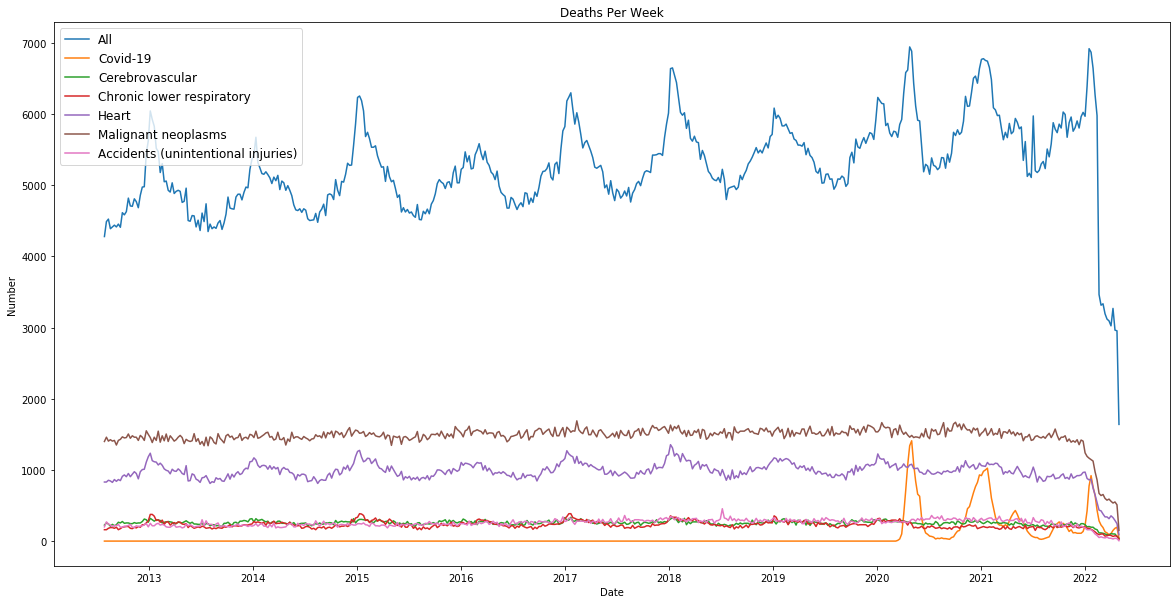

In [286]:
fig, ax_compare = plt.subplots(figsize=(20, 10) ) 
plt.title('Deaths Per Week')
plt.xlabel('Date')
plt.ylabel('Number')
ax_compare.plot(OrderByDateList, label='All')
ax_compare.plot(Covid, label='Covid-19')
ax_compare.plot(Cerebro, label='Cerebrovascular')
ax_compare.plot(Resp, label='Chronic lower respiratory')
ax_compare.plot(Heart, label='Heart')
ax_compare.plot(Neo, label='Malignant neoplasms')
ax_compare.plot(Accidents, label='Accidents (unintentional injuries)')
#Turn log scale on and off
#ax_compare.set_yscale('log')
ax_compare.legend(loc='upper left', fontsize=12)
fig = ax_compare.get_figure()
fig.savefig("Images/Cause.png")